                                             Workshop 2: Pete Hellyer - Edited from  Dragos Gruia and Valentina Giunchiglia

# Introduction to structural and functional MRI analysis in Python

The aim of the workshop of today is to introduce you to the analysis functional MRI data using Python.

- **Structural MRI**: provides information about the anatomy and pathology of the brain
- **Functional MRI**: provides information about the brain activity

In the workshop today, we will start to teach you how to manage and understand these imaging data, and how to conduct some basic analysis. In this session, we will look at some correlation analysies of functional data, and look at how to fit a task to data.


The data for the lecture of today are saved in the format of a `pickle` object. Pickle is a module in python that can be used to store and save python objects, in the `pickle` format. The first thing you need to do is to import the module, together with other modules you will need in the workshop.

In [1]:
import scipy.io
import matplotlib.pyplot as plt
from scipy.stats import shapiro
import pickle
import seaborn as sb
import pandas as pd
%matplotlib inline
import numpy as np
import os
import warnings

warnings.filterwarnings('ignore')

sb.set_theme("talk")
sb.set_style("whitegrid")

To open and save python objects in the pickle format, you need to use `context managers`, which you should have learnt during the first lecture of the primer material. Let's start by loading the fMRI (functional MRI) and sMRI (structural MRI) data.

In [2]:
with open('Data/fmri_day4.pickle', 'rb') as handle:
    fmri = pickle.load(handle)
    
with open('Data/smri_day4.pickle', 'rb') as handle:
    smri = pickle.load(handle)

------

## Functional connectivity analysis

In the last workshop - we plotted the timecourses from various voxels in our fMRI data to understand how fMRI data is stored and strucutred. Apart from plotting the timecourses, you can also plot a scatterplot to observe whether the timecourse of two voxels is correlated. This is important because if the signal of two voxels is correlated, it might mean that the brain acitivity of one of the regions depends on the activity of the other region.

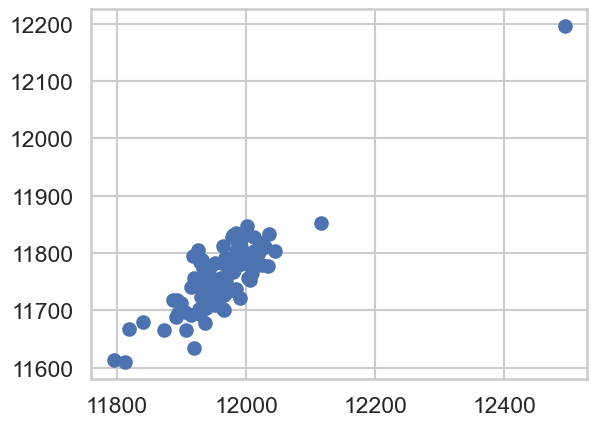

In [3]:
_ = plt.scatter(fmri[8,8,8,:], fmri[8,9,8,:])

**Functional connectivity** describes how the timecourse of two brain regions statistically depend on each other. There are various functional connectivity metrics. One of the simplest ways to measure this statistical dependency is to calculate the Pearson's correlation between the timecourses of two separate voxels. Let's try to select two voxels and calculate their correlation.

In [4]:
voxel1 = fmri[13,8,9,:]
voxel2 = fmri[10,3,9,:]

In [5]:
np.corrcoef(voxel1, voxel2)

array([[1.        , 0.63143795],
       [0.63143795, 1.        ]])

The output of the function is the correlation coefficient **R**. Since the ouput is a diagonal matrix, to extract the correlation coefficient, you can extract the second element of the first array, or the first element of the second array.

In [6]:
np.corrcoef(voxel1, voxel2)[0][1]

0.6314379526141778

 As you should already know, the correlation coefficient can have any value between -1 and 1. The closer is the value to -1 or 1, the stronger the linear relationship between the two timecourses. The greater is the absolute value, the stronger is the relationship. A positive coefficient indicates that when the signal of one voxel increases, the signal of the other voxels also tends to increase. Instead, a negative coefficient means that when the signal of one voxel increases, the signal of the other voxel tends to decrease. In this case, there is a moderate, positive, correlation between the two selected voxels, which means that the two voxels appear to have similar timecourses.

However, to be able to interpret what this actually means, it is important to understand where the voxels are located in the brain. It is possible to do this by simply creating a copy of your original fmri image and replacing the value of the voxel of interest with a 0. In this way, you will be easily able to see where the voxel is when you create a plot, because the voxel will be completely black.

**IMPORTANT**: you must create a copy of the image, or you will lose the real signal information of the voxel you are studying. You should use the copy ONLY for visualization purposes and not for the analysis.

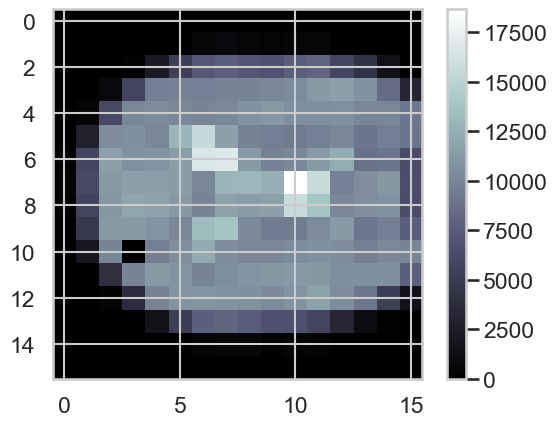

In [7]:
fmriview = fmri.copy()
fmriview[10,3,9,1] = 0
plt.imshow(fmriview[:, :, 9, 1], cmap = "bone")
plt.colorbar()

As you can see the voxel is more or less located in the occipital cortex. As a reference, you can use the following (or any other) figure.

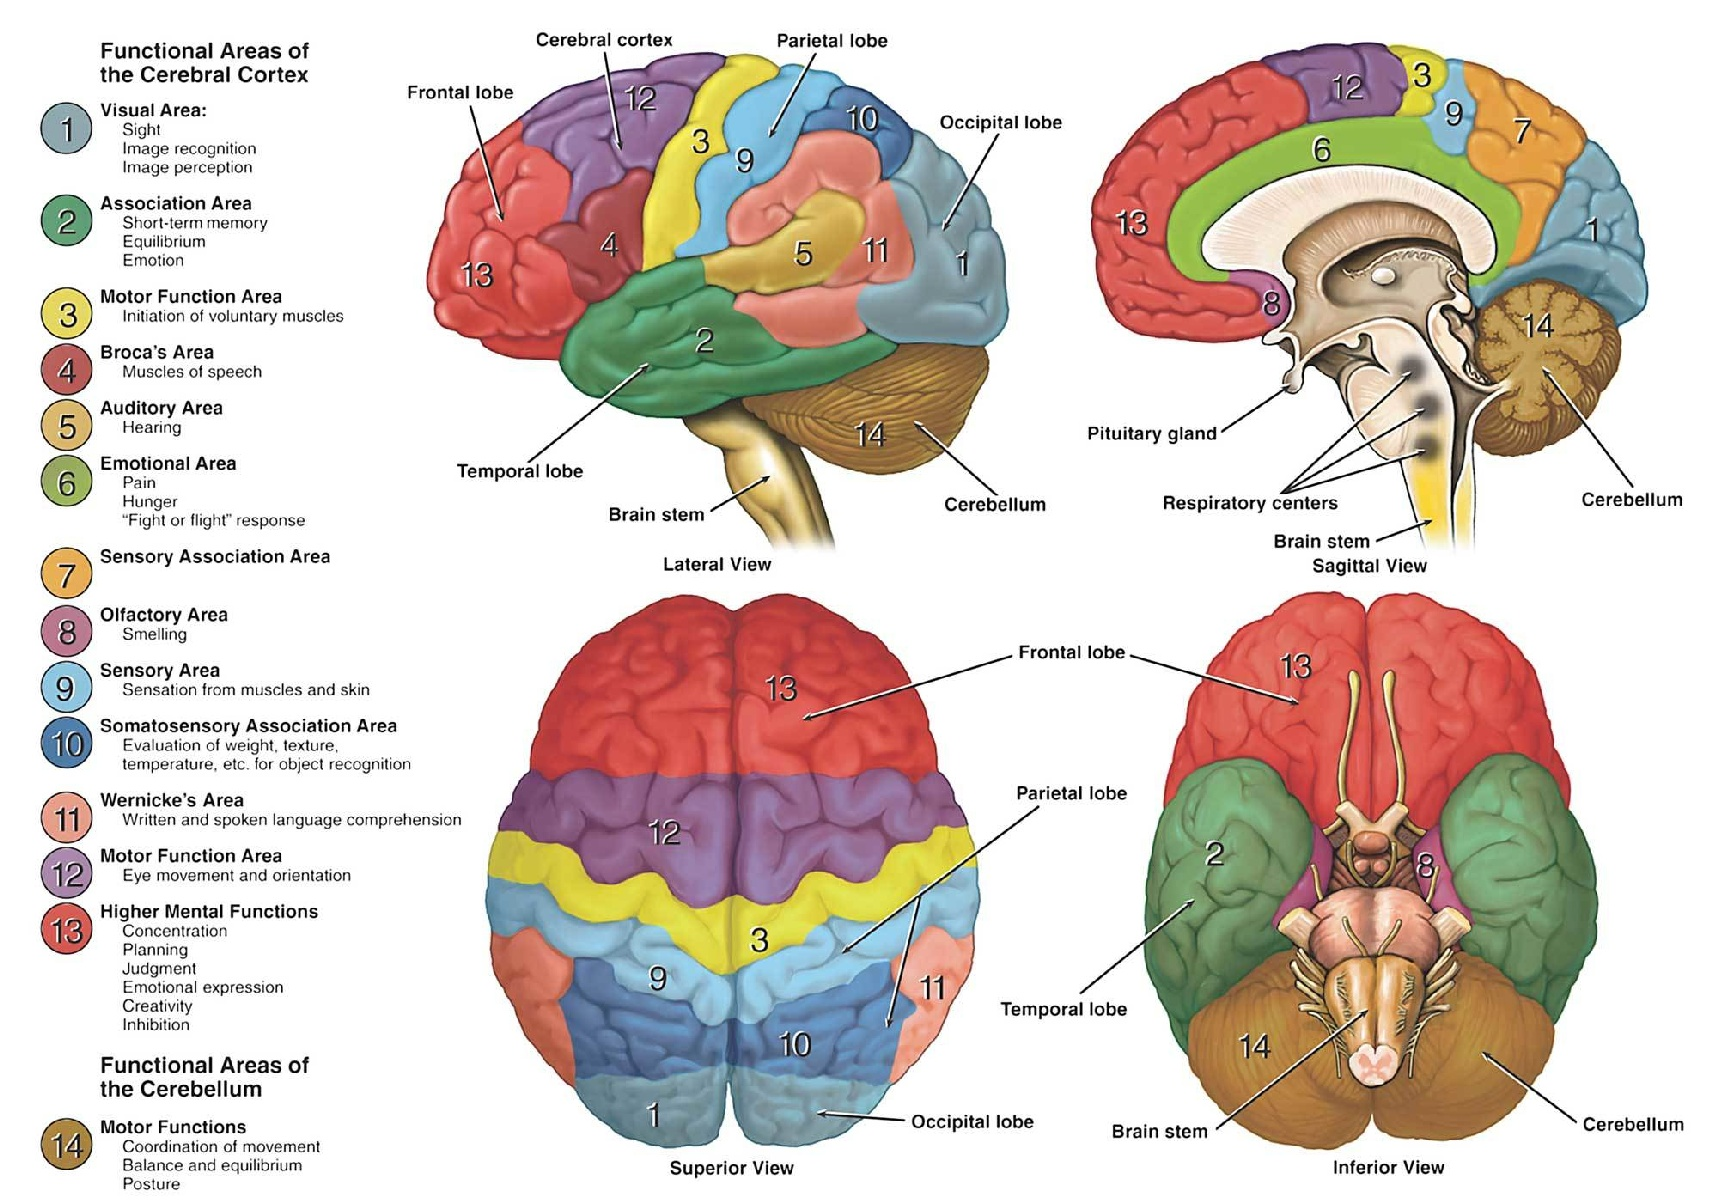

------
## Code here

Select a couple of voxels located in different regions of the brain and calculate the correlation coefficient. How does it change?

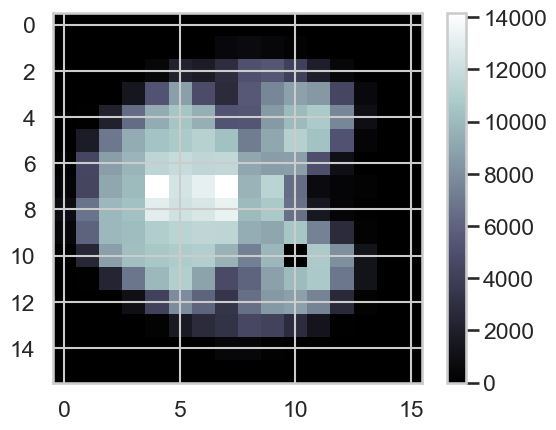

In [8]:
## pick a voxel that is located broadly in the temporal pole
fmriview = fmri.copy()
fmriview[10,10,6,1] = 0
plt.imshow(fmriview[:, :, 6, 1], cmap = "bone")
plt.colorbar()
# the voxel at 10, 10, 6 is in the temporal pole

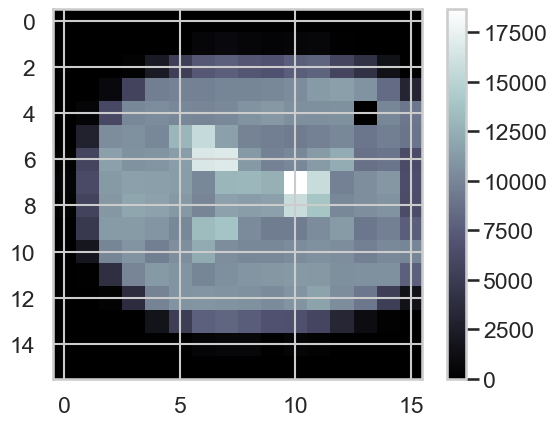

In [9]:
## Pick a voxel that is located broadly in the frontal lobe
fmriview = fmri.copy()
fmriview[4,13,9,1] = 0
plt.imshow(fmriview[:, :, 9, 1], cmap = "bone")
plt.colorbar()
# the voxel at 4, 13, 9 is located broadly in the frontal lobe.

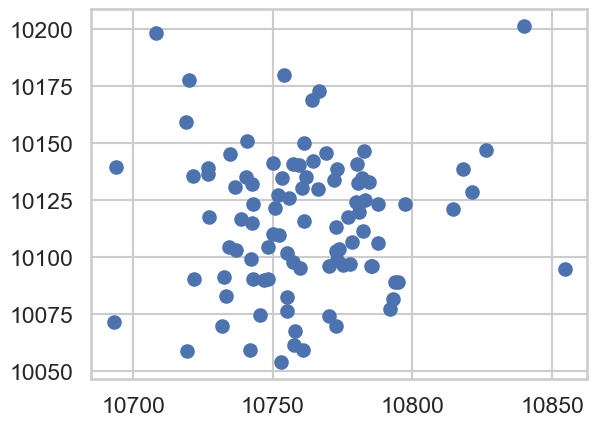

In [10]:
# Firstly, we'll plot them against each other
temporal_voxel = fmri[10,10,6,:]
frontal_voxel = fmri[4,13,9,:]

_ = plt.scatter(temporal_voxel, frontal_voxel)

In [11]:
#These dont look very correlated at all - lets confirm that:
np.corrcoef(temporal_voxel, frontal_voxel)


array([[1.        , 0.05159636],
       [0.05159636, 1.        ]])

--------

The problem with the above approach is that you need to manually select each voxel and then run the correlation analysis. A quicker method is to run a whole brain functional connectivity analysis, which essentially takes one voxel, called the **seed** voxel and calculates the correlation between the seed and all the other voxels in the brain. 

To be able to do this, it is necessary to use three `For Loops`, which you should have learnt as part of the primer material. The reason why we need three `For Loops` is that we need to loop over all possible combinations of x, y and z coordinates. More specifically, we need to complete the following steps:

1. Create an all zero array with the same (x, y, z) shape of the fMRI data. We will use this array as a placeholder, and will replace the (x,y,z) value of the array with the correlation coefficient between the seed voxel and the voxel located in (x,y,z)
2. Identify the seed voxel (we will use here the voxel located in the visual cortex)
3. Loop over all x, y and z possible coordinates
4. Calculate the correlation between the (x,y,z) voxel and the seed voxel
5. Replace the 0 value of the all zero array with the correlation coefficient

In [12]:
fmri.shape[0:3]

(16, 16, 16)

In [13]:
seed_voxel = fmri[10,3,9,:]
FunctionalConnectivityResults = np.zeros(fmri.shape[0:3])
for x in range(fmri.shape[0]):
    for y in range(fmri.shape[1]):
        for z in range(fmri.shape[2]):
            new_voxel = fmri[x,y,z,:]
            corr_voxels = np.corrcoef(seed_voxel, new_voxel)[0][1]
            FunctionalConnectivityResults[x,y,z] = corr_voxels

Now, **FunctionalConnectivityResults** contains all the correlation coefficients between the seed voxels and the other voxels. To visualize them you can print them or plot them.

In [14]:
FunctionalConnectivityResults[2,10, 9]

0.6188145074545621

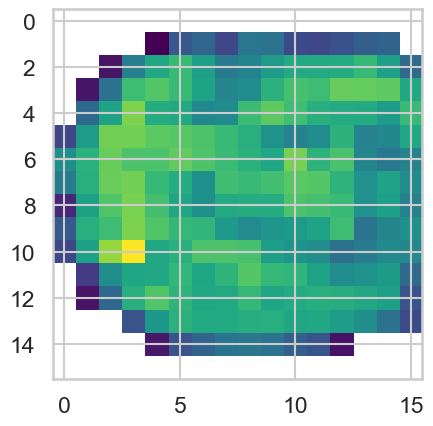

In [15]:
plt.imshow(FunctionalConnectivityResults[:,:, 9], cmap = "viridis")

Try to check the correlation coefficient value in the seed voxel coordinates. Why do you think it is like that?

Now try to check the value at x=1, y=1, z=1

In [16]:
# let's look at the value we calculated at the location 1,1,1

FunctionalConnectivityResults[1,1,1]

nan

If you did it correctly, you should see that the value is **nan**. This nan corresponds to the white regions in the above figure, and to the areas in the image that are outside the brain (e.g. the background). We don't really need to calculate the correlation between the background and the seed voxel, because it just increases the amount of calculation that need to be computed, and the time required to compute them. This is a big waste of computational resources, mainly when running more complex analysis, rather than a simple correlation. 

In order to avoid running calculations that are not needed, we can use the information contained in the *brain mask*. The brain mask is a separate image that specifies which part of the fMRI images belong to the brain, and which parts to the background. To do that, it assigns a value of 1 to the brain regions, and a value of 0 to the background regions. Let's import the brain mask to see how it looks.

In [17]:
with open('Data/brainmask.pickle', 'rb') as handle:
    mask = pickle.load(handle)

In [18]:
mask.shape

(16, 16, 16)

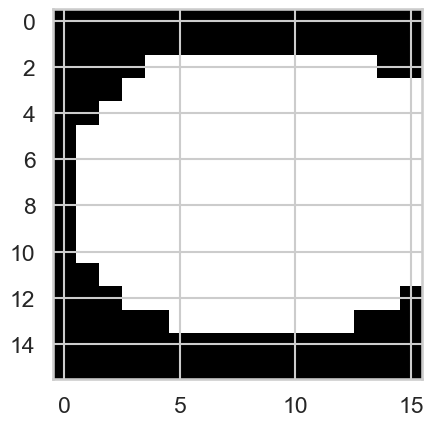

In [19]:
plt.imshow(mask[:, :, 9], cmap = "bone")

As you can see the (x, y, z) shape of the mask is equivalent to the (x, y, z) shape of the fMRI image. If you plot it, you can see in white the parts that belong to the brain, and in black those that belong to the background. In order to use the information contained in this mask, we can ass an additional if statement that specifies that the correlation should be computed **ONLY** if the (x,y,z) value in the mask is equal to 1.

In [20]:
seed_voxel = fmri[10,3,9,:]
FunctionalConnectivityResults = np.zeros(fmri.shape[0:3]) # Create a variable full of zeros, which will later be replaced by the correlations coefficients we obtain between voxels
for x in range(fmri.shape[0]):
    for y in range(fmri.shape[1]):
        for z in range(fmri.shape[2]):
            if mask[x, y, z] == 1:
                new_voxel = fmri[x,y,z,:]
                corr_voxels = np.corrcoef(seed_voxel, new_voxel)[0][1] #Run a correlation between the seed voxel and another voxel in the brain
                FunctionalConnectivityResults[x,y,z] = corr_voxels #Replace the zeros with the correlation values

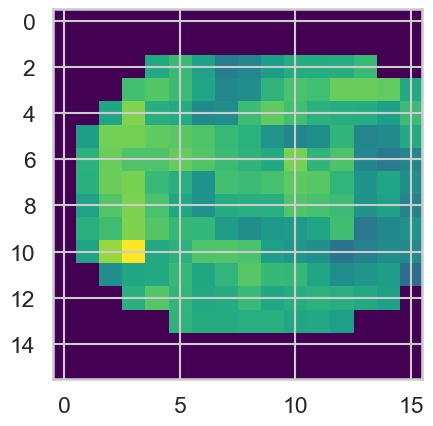

In [21]:
plt.imshow(FunctionalConnectivityResults[:,:, 9], cmap = "viridis")

In [22]:
FunctionalConnectivityResults[1,1,1]

0.0

Now, as you can see, the value in the background regions is equal to 0, which means that the original 0 value was not updated, since no correlation was computed.

## Whole brain regression analysis

A more advanced alternative to whole brain functional connectivity analysis is **whole brain regression analysis**. As you should already know, regression analysis consists of trying to predict a variable Y based on one or more variables X (called regressors). The strength of regression analysis compared to simple correlation is that it allows you to have more than one X, which means that it is possible to account for other factors when studying the association (such as cofounding factors). We will understand thoughout the lecture why this is important. For now, let's start by running the whole brain regression analysis only using the timecourses of two voxels.

The code will remain pretty much the same as the one for the functional connecitivity analysis, with the difference that now instead of running the correlation, we will run a regression and store three different outputs: the p values, t statistic and beta coefficients. The reason why we add a [1] when extracting the p values, t stats and beta coefficients is that we want to get the values that correspond to the timecourse of the other voxel and not of the intercept (or constant term) (which is at index 0).

The constant term accounts for the fluctuations in the signal that are not predicted by the timecourse of the voxel X. 

(to start, you might need to install statsmodels, but this was included in the setup notes)

In [4]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [24]:
import statsmodels.api as sm

In [25]:
seed_voxel = fmri[10,4,9,:]

RegressionPvalues = np.zeros(fmri.shape[0:3])
RegressionTstats = np.zeros(fmri.shape[0:3])
RegressionBeta = np.zeros(fmri.shape[0:3])

for x in range(fmri.shape[0]):
    for y in range(fmri.shape[1]):
        for z in range(fmri.shape[2]):
            if mask[x, y, z] == 1:
                new_voxel = fmri[x,y,z,:]
                mod = sm.OLS(new_voxel, sm.add_constant(seed_voxel), hasconst=True).fit() #Run the regression model between the two voxels
                RegressionTstats[x,y,z] = mod.tvalues[1] #save the t-value of the independent value (e.g. the voxel timecourse)
                RegressionPvalues[x,y,z] = mod.pvalues[1] #save the p-value of the independent value
                RegressionBeta[x,y,z] = mod.params[1] #save beta coef of the independent value 

Let's look at all the results. Before plotting the images, we set as nan the values in the seed voxel location, because they represent the results of the regression of the seed voxel with itself.

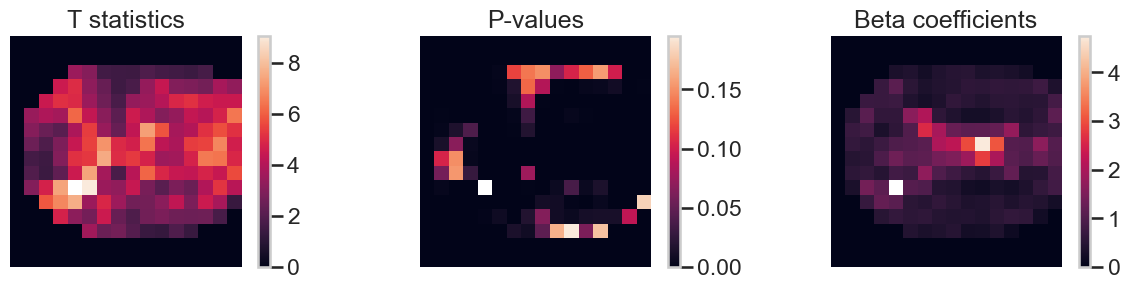

In [26]:
RegressionTstats[10,4,9] = np.nan
RegressionPvalues[10,4,9] = np.nan
RegressionBeta[10,4,9] = np.nan

plt.figure(figsize = (15,3))
plt.subplot(131)
plt.imshow(RegressionTstats[:,:, 9])
plt.title("T statistics")
plt.axis("off")
plt.colorbar()
plt.subplot(132)
plt.imshow(RegressionPvalues[:,:, 9])
plt.title("P-values")
plt.axis("off")
plt.colorbar()
plt.subplot(133)
plt.imshow(RegressionBeta[:,:, 9])
plt.title("Beta coefficients")
plt.axis("off")
plt.colorbar()

Try to pick another seed voxel and see how the results change.


In [28]:
# lets pick that voxel we used earlier in the temporal lobe.  (10, 10 6)


seed_voxel = fmri[10,10,6,:]

RegressionPvalues = np.zeros(fmri.shape[0:3])
RegressionTstats = np.zeros(fmri.shape[0:3])
RegressionBeta = np.zeros(fmri.shape[0:3])

for x in range(fmri.shape[0]):
    for y in range(fmri.shape[1]):
        for z in range(fmri.shape[2]):
            if mask[x, y, z] == 1:
                new_voxel = fmri[x,y,z,:]
                mod = sm.OLS(new_voxel, sm.add_constant(seed_voxel), hasconst=True).fit() #Run the regression model between the two voxels
                RegressionTstats[x,y,z] = mod.tvalues[1] #save the t-value of the independent value (e.g. the voxel timecourse)
                RegressionPvalues[x,y,z] = mod.pvalues[1] #save the p-value of the independent value
                RegressionBeta[x,y,z] = mod.params[1] #save beta coef of the independent value 


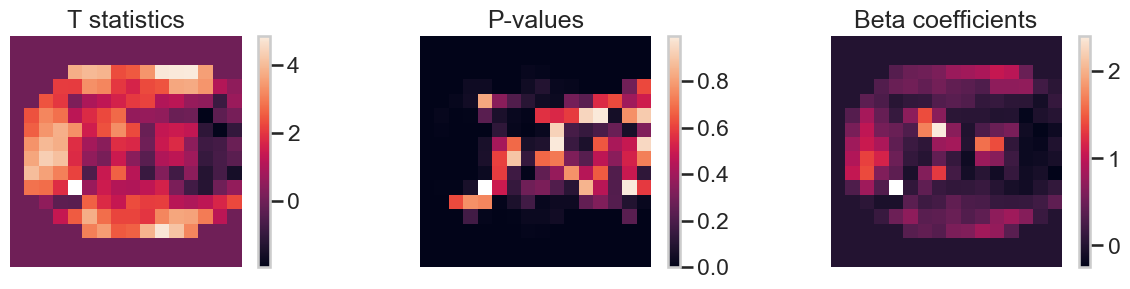

In [29]:
# then plot everything out

RegressionTstats[10,4,9] = np.nan
RegressionPvalues[10,4,9] = np.nan
RegressionBeta[10,4,9] = np.nan

plt.figure(figsize = (15,3))
plt.subplot(131)
plt.imshow(RegressionTstats[:,:, 9])
plt.title("T statistics")
plt.axis("off")
plt.colorbar()
plt.subplot(132)
plt.imshow(RegressionPvalues[:,:, 9])
plt.title("P-values")
plt.axis("off")
plt.colorbar()
plt.subplot(133)
plt.imshow(RegressionBeta[:,:, 9])
plt.title("Beta coefficients")
plt.axis("off")
plt.colorbar()


Now that we know how to run some basic regression analysis with fMRI data, we can make a step forward and try to add multiple variables as regressors apart from the voxel timecourse. As mentioned earlier, one of the strength of regression analysis is that it allows to covary out signals that might be random noise or artefact (since it can take more than one X), such as those that are caused by head motion. Head motion is one of the biggest sources of noise in fMRI data, and one approach to account for it is to add it as a regressor when running the linear regression model. In this way, it is possible to calculate the statistical relationship between voxel timecourses that is not the result of the motion timecourse. 

Let's import the head motion timecourse and check the shape.                                            

In [31]:
with open('Data/motion_day4.pickle', 'rb') as handle:
    motion = pickle.load(handle)

In [32]:
motion.shape, motion[1:10]

((96, 1),
 array([[0.09384  ],
        [0.0309833],
        [0.0702182],
        [0.0781624],
        [0.0523351],
        [0.0551896],
        [0.0523202],
        [0.0294705],
        [0.0248516]]))

As you can see, the motion timecourse provides a measure of head movement for each timepoint of fMRI image collection. The weird thing is that the array, although it should be 1 dimensional, it appears to have 2 dimensions. To fix this, we can use the methos squeeze().

In [33]:
motion = motion.squeeze()
motion.shape

(96,)

Now we can use it in the whole brain regression analysis. 

In [34]:
seed_voxel = fmri[10,4,9,:]

RegressionPvaluesMotion = np.zeros(fmri.shape[0:3])
RegressionTstatsMotion = np.zeros(fmri.shape[0:3])
RegressionBetaMotion = np.zeros(fmri.shape[0:3])

for x in range(fmri.shape[0]):
    for y in range(fmri.shape[1]):
        for z in range(fmri.shape[2]):
            if mask[x, y, z] == 1:
                new_voxel = fmri[x,y,z,:]
                X = pd.DataFrame({"Voxel": seed_voxel, "Motion": motion}) # Set X as your independent variables, i.e. the voxel timecourse and the motion timecourse
                mod = sm.OLS(new_voxel, sm.add_constant(X.values), hasconst=True).fit() # Run the regression model
                
                RegressionTstatsMotion[x,y,z] = mod.tvalues[1] # Save the t-value 
                RegressionPvaluesMotion[x,y,z] = mod.pvalues[1] # Save the p-value
                RegressionBetaMotion[x,y,z] = mod.params[1] # Save the beta coef

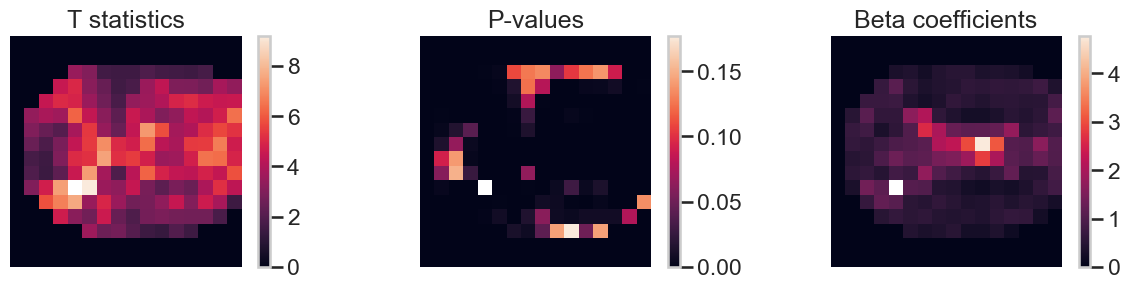

In [35]:
RegressionTstatsMotion[10,4,9] = np.nan
RegressionPvaluesMotion[10,4,9] = np.nan
RegressionBetaMotion[10,4,9] = np.nan

plt.figure(figsize = (15,3))
plt.subplot(131)
plt.imshow(RegressionTstatsMotion[:,:, 9])
plt.title("T statistics")
plt.axis("off")
plt.colorbar()
plt.subplot(132)
plt.imshow(RegressionPvaluesMotion[:,:, 9])
plt.title("P-values")
plt.axis("off")
plt.colorbar()
plt.subplot(133)
plt.imshow(RegressionBetaMotion[:,:, 9])
plt.title("Beta coefficients")
plt.axis("off")
plt.colorbar()

By looking at the results, it is not easy to see any difference, which suggests that motion is not playing a big role. However, if you check the values individually, you will see that the value changed, even if only slightly. 

In [36]:
print("Before:", RegressionTstats[8, 6, 9])
print("After:", RegressionTstatsMotion[8, 6, 9])

Before: 0.1340503732532057
After: 7.483849706779466


---------
## Code here

Repeat the whole brain regression analysis, but this time:
1. Plot the beta coefficient, t statistics and p values plots for the head motion rather than the voxel timecourse. This will allow you to see whether and to which extent the head motion plays a role.
2. We are not limited to covarying out the effect of motion, but also could remove other non-neural noise sources. For example it is common to remove timecourses taken from white matter and cerebrospinal fluid (where neural signal cannot originate) as well as motion. Try to rerun the regression analysis, but this time add as additional regressor the timecourse of a voxel located in the white matter or cerebrospinal fluid. Use the following image as a reference to locate the right voxels.
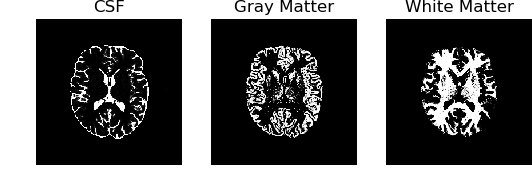


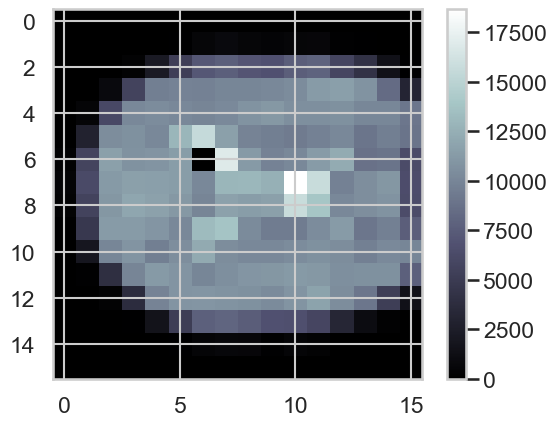

In [39]:
# Ok, lets pick some voxels that live in each of these areas, (and plot them to prove it)
CSF_Voxel = [6,6,9]

fmriview = fmri.copy()
fmriview[CSF_Voxel[0],CSF_Voxel[1],CSF_Voxel[2],1] = 0
plt.imshow(fmriview[:, :, CSF_Voxel[2], 1], cmap = "bone")
plt.colorbar()
# the voxel at 6,6,9 is in the lateral ventricle.



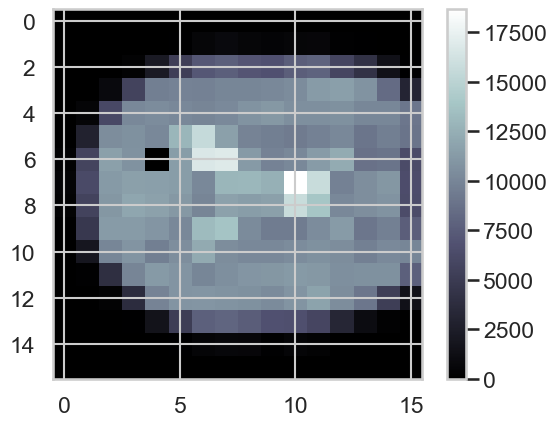

In [45]:
# Ok, lets pick some voxels that live in each of these areas, (and plot them to prove it)
WM_Voxel = [6,4,9]

fmriview = fmri.copy()
fmriview[WM_Voxel[0],WM_Voxel[1],WM_Voxel[2],1] = 0
plt.imshow(fmriview[:, :, WM_Voxel[2], 1], cmap = "bone")
plt.colorbar()
# the voxel at 3, 4, 9, is in the white matter


In [48]:
# now, lets create our regressors

WM_Regressor = fmri[WM_Voxel[0],WM_Voxel[1],WM_Voxel[2],:]
CSF_Regressor = fmri[CSF_Voxel[0],CSF_Voxel[1],CSF_Voxel[2],:]

# and apply them to the stats model

seed_voxel = fmri[10,4,9,:]

RegressionPvaluesMotion = np.zeros(fmri.shape[0:3])
RegressionTstatsMotion = np.zeros(fmri.shape[0:3])
RegressionBetaMotion = np.zeros(fmri.shape[0:3])

for x in range(fmri.shape[0]):
    for y in range(fmri.shape[1]):
        for z in range(fmri.shape[2]):
            if mask[x, y, z] == 1:
                new_voxel = fmri[x,y,z,:]
                X = pd.DataFrame({"Voxel": seed_voxel, "Motion": motion, "WM": WM_Regressor, "CSF": CSF_Regressor}) # Set X as your independent variables, i.e. the voxel timecourse and the motion timecourse
                mod = sm.OLS(new_voxel, sm.add_constant(X.values), hasconst=True).fit() # Run the regression model
                
                RegressionTstatsMotion[x,y,z] = mod.tvalues[1] # Save the t-value 
                RegressionPvaluesMotion[x,y,z] = mod.pvalues[1] # Save the p-value
                RegressionBetaMotion[x,y,z] = mod.params[1] # Save the beta coef
                


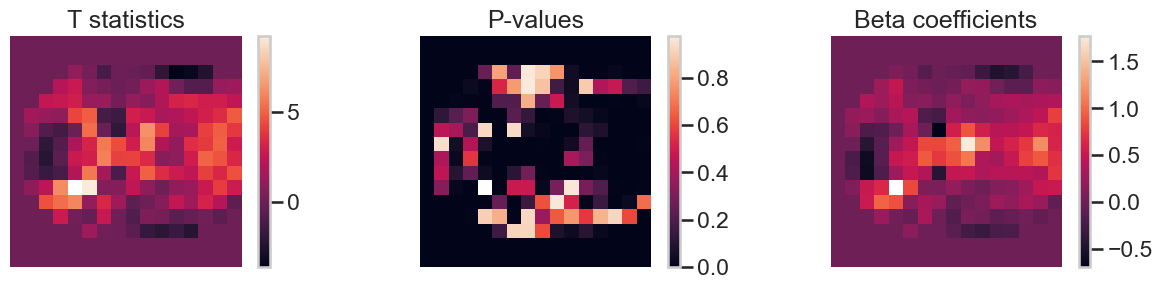

In [49]:
# Now Plot the statistics


RegressionTstatsMotion[10,4,9] = np.nan
RegressionPvaluesMotion[10,4,9] = np.nan
RegressionBetaMotion[10,4,9] = np.nan

plt.figure(figsize = (15,3))
plt.subplot(131)
plt.imshow(RegressionTstatsMotion[:,:, 9])
plt.title("T statistics")
plt.axis("off")
plt.colorbar()
plt.subplot(132)
plt.imshow(RegressionPvaluesMotion[:,:, 9])
plt.title("P-values")
plt.axis("off")
plt.colorbar()
plt.subplot(133)
plt.imshow(RegressionBetaMotion[:,:, 9])
plt.title("Beta coefficients")
plt.axis("off")
plt.colorbar()

In [50]:
print("Before:", RegressionTstats[8, 6, 9])
print("After:", RegressionTstatsMotion[8, 6, 9])

Before: 0.1340503732532057
After: 5.819766537568504


--------

## Task activation analysis

Until now, we tried to predict the timecourse of a seed voxel using the timecourse of the other brain voxels, after accounting for head motions or other factors. However, when you do a task fMRI experiment, what you really want to understand is which brain regions are activated while the participant is completing one or other task condition. In the case of our data, the task was characterised by a block design, which means that the participants had alternating blocks of time in which they were doing a task or were at rest. If a voxel is activated as a result of the task, we would expect the signal of that voxel to be higher during the task block and be lower during the rest block.

A way to measure this is to run whole brain regression analysis, but this time the task timecourse, which specifies when exactly the rest and task occured,  will be used to predict the voxel timecourse. In this way, it will be possible to understand how much of the voxel timecourse can be explained by the task timecourse. Let's import the task timecourse and check it out.

In [71]:
with open('Data/tasktc_day4.pickle', 'rb') as handle:
    task_tc = pickle.load(handle)

([], [])

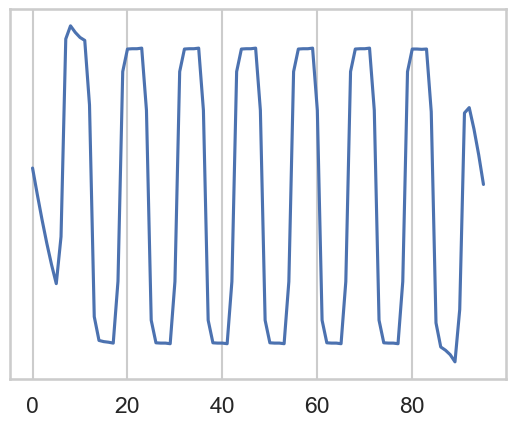

In [52]:
plt.plot(task_tc)
plt.yticks([])

As you can see from the plot, the times where the peaks are located correpond to the task block, instead those where the minima are located correspond to the rest block. If a voxel was active only during the task, and not at rest, we would expect to see a similar pattern when looking at the voxel signal. Of course this is just one task design,  but many others are possible. For example, if you were showing two types of stimuli at the same time and would like to understand the brain activation for each one of them, then you would have to add two separate regressors, or X, in your model.

 One regressor that describes when the first stimulus occurred, and one regressor that describes when the second stimulus occurred. After fitting the model, you would get beta coefficients, t-stats and p-values for each one of those regressors, which would give you information about the brain activation during each one of the stimuli. 

------
## Code here

Modify the code above to run whole brain regression analysis, but this time using as X the task timecourse AND the motion, and as Y the voxel timecourse. Call the results RegressionTstatsTask, RegressionPvaluesTask and RegressionBetaTask

**Tips**: Check the shape of task_tc. Is it a 1D array as it should? If not, don't forget to address that!

In [72]:
# Ok, lets firstly check the shape of task_tc
task_tc.shape

(96, 1)

In [78]:
#it looks ok, but we'll use squeeze to force it to be 1D anyway, just to be safe.
task_tc = np.squeeze(task_tc)

task_tc.shape

(96,)

In [84]:
# we can use the same code we had above, but we're looking at at a task this time, rather than a functional connectivity pattern for an individual voxel, so we can swap out 'Voxel' for the task timecourse

RegressionPvaluesTask = np.zeros(fmri.shape[0:3])
RegressionTstatsTask = np.zeros(fmri.shape[0:3])
RegressionBetaTask = np.zeros(fmri.shape[0:3])

for x in range(fmri.shape[0]):
    for y in range(fmri.shape[1]):
        for z in range(fmri.shape[2]):
            if mask[x, y, z] == 1:
                new_voxel = fmri[x,y,z,:]
                X = pd.DataFrame({"Task": task_tc}) # Set X as your independent variables, i.e. the voxel timecourse and the motion timecourse
                mod = sm.OLS(new_voxel, sm.add_constant(X.values), hasconst=True).fit() # Run the regression model


                # obviously, these 
                RegressionTstatsTask[x,y,z] = mod.tvalues[1] # Save the t-value 
                RegressionPvaluesTask[x,y,z] = mod.pvalues[1] # Save the p-value
                RegressionBetaTask[x,y,z] = mod.params[1] # Save the beta coef
                


--------

Once you completed the above exercise, try to visualise the results.

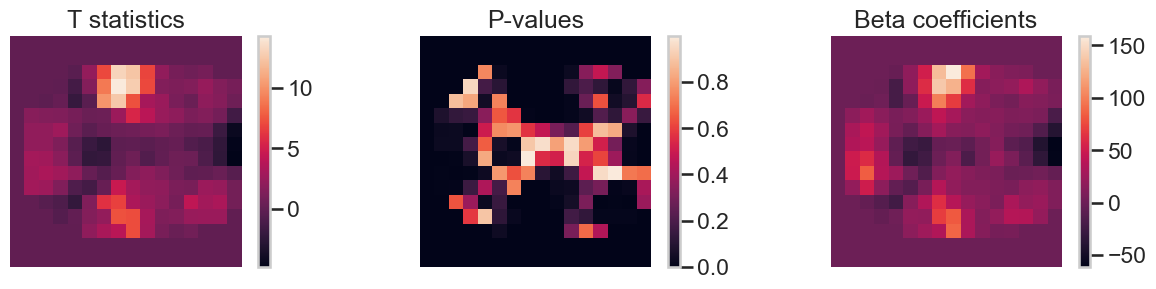

In [85]:
plt.figure(figsize = (15,3))
plt.subplot(131)
plt.imshow(RegressionTstatsTask[:,:, 9])
plt.title("T statistics")
plt.axis("off")
plt.colorbar()
plt.subplot(132)
plt.imshow(RegressionPvaluesTask[:,:, 9])
plt.title("P-values")
plt.axis("off")
plt.colorbar()
plt.subplot(133)
plt.imshow(RegressionBetaTask[:,:, 9])
plt.title("Beta coefficients")
plt.axis("off")
plt.colorbar()

As you can see, the t-statistics is a bit noisy because it includes also the values of the non-significant voxels. To improve this, we can savethe t-statistics **only** if the p-value is below a chosen threshold, such as 0.05.

-------
## Code here

Modify the code above to run whole brain regression analysis, but this time using as X the task timecourse AND the motion, and as Y the voxel timecourse. Call the results RegressionTstatsTask, RegressionPvaluesTask and RegressionBetaTask. Add an if statement, according to which the t statistics is saved in *RegressionTstatsTask* only if the p-value is below 0.05.

**Tips**: Check the shape of task_tc. Is it a 1D array as it should? If not, don't forget to address that!

In [87]:
# we can use the same code we had above, but we're looking at at a task this time, rather than a functional connectivity pattern for an individual voxel, so we can swap out 'Voxel' for the task timecourse

WM_Regressor = fmri[WM_Voxel[0],WM_Voxel[1],WM_Voxel[2],:]
CSF_Regressor = fmri[CSF_Voxel[0],CSF_Voxel[1],CSF_Voxel[2],:]

RegressionPvaluesTask = np.zeros(fmri.shape[0:3])
RegressionTstatsTask = np.zeros(fmri.shape[0:3])
RegressionBetaTask = np.zeros(fmri.shape[0:3])

for x in range(fmri.shape[0]):
    for y in range(fmri.shape[1]):
        for z in range(fmri.shape[2]):
            if mask[x, y, z] == 1:
                new_voxel = fmri[x,y,z,:]
                X = pd.DataFrame({"Task": task_tc, "Motion": motion, "WM": WM_Regressor, "CSF": CSF_Regressor}) # Set X as your independent variables, i.e. the voxel timecourse and the motion timecourse
                mod = sm.OLS(new_voxel, sm.add_constant(X.values), hasconst=True).fit() # Run the regression model


                # obviously, these 
                RegressionTstatsTask[x,y,z] = mod.tvalues[1] # Save the t-value 
                RegressionPvaluesTask[x,y,z] = mod.pvalues[1] # Save the p-value
                RegressionBetaTask[x,y,z] = mod.params[1] # Save the beta coef
                

-------

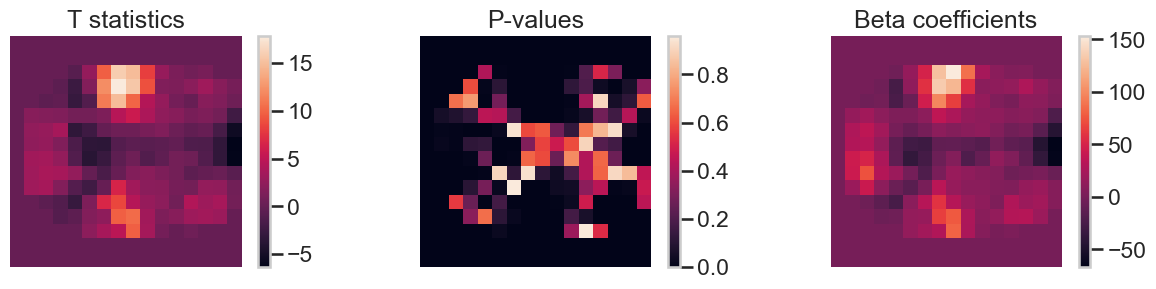

In [88]:
plt.figure(figsize = (15,3))
plt.subplot(131)
plt.imshow(RegressionTstatsTask[:,:, 9])
plt.title("T statistics")
plt.axis("off")
plt.colorbar()
plt.subplot(132)
plt.imshow(RegressionPvaluesTask[:,:, 9])
plt.title("P-values")
plt.axis("off")
plt.colorbar()
plt.subplot(133)
plt.imshow(RegressionBetaTask[:,:, 9])
plt.title("Beta coefficients")
plt.axis("off")
plt.colorbar()

Now the results appear much cleaner. Based on the results, can you understand which task the participants were completed? Use the image above to try to understand which brain regions are activated.
